In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import roc_auc_score, roc_curve, auc,confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [53]:
# Load the data
data = pd.read_csv('Amazon_data.csv')

# Display the first few rows of the dataframe to understand its structure
print(data.head())


       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...        5   
1  The product does exactly as it should and is q...        5   
2  The primary job of this device is to block the...        5   
3  Nice windscreen protects my MXL mic and preven...        5   
4  This pop filter is great. It looks and perform...        5   

                   

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10234 non-null  object
 3   helpful         10261 non-null  object
 4   reviewText      10254 non-null  object
 5   overall         10261 non-null  int64 
 6   summary         10261 non-null  object
 7   unixReviewTime  10261 non-null  int64 
 8   reviewTime      10261 non-null  object
dtypes: int64(2), object(7)
memory usage: 721.6+ KB


DATA EXPLORATION 

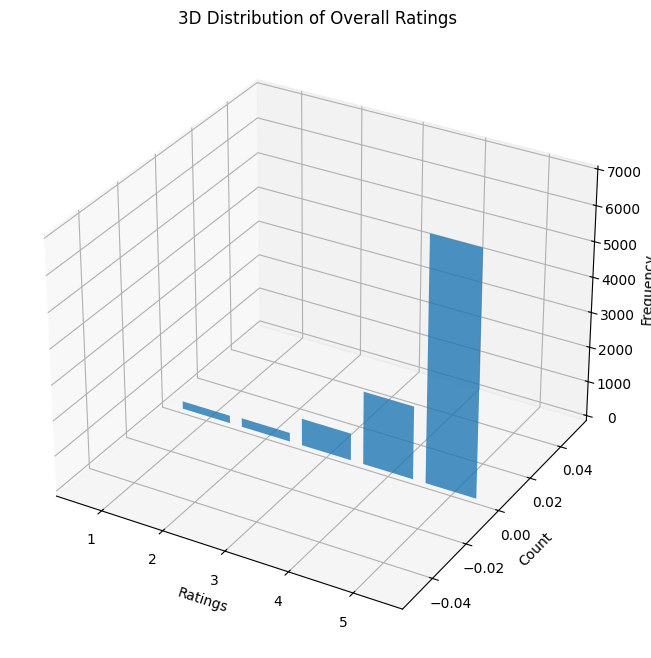

In [55]:
 #Distribution of overall rating 

rating_counts = data['overall'].value_counts().sort_index()
x = rating_counts.index
y = rating_counts.values
z = np.zeros_like(y)

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.bar(x, y, zs=z, zdir='y', alpha=0.8)

ax.set_xlabel('Ratings')
ax.set_ylabel('Count')
ax.set_zlabel('Frequency')
ax.set_title('3D Distribution of Overall Ratings')
plt.show()


DATA PREPROCESSING STEPS 

In [56]:
# Use both 'reviewText' and 'summary' columns for features
X = data[['reviewText', 'summary']]


# check for missing values
null = data.isnull ().sum()
print(null)






reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64


In [57]:
data_cleaned = data.dropna(subset=['reviewText'], inplace=True)
null = data.isnull ().sum()
print(null)

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64


In [58]:
X = data[['reviewText', 'summary']]

# Combine 'reviewText' and 'summary' into a single column
X['combined'] = X['reviewText'] + " " + X['summary']

# Convert labels to categorical
y = data['overall']
y = pd.get_dummies(y).values


C:\Users\HP\AppData\Local\Temp\ipykernel_19304\1972612549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['combined'] = X['reviewText'] + " " + X['summary']


SPLITING THE DATA AND ALSO ENSURING ALL THE DATA IN OUR TARGET PARAMETER ARE ALL STRING 

In [59]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X['combined'], y, test_size=0.2, random_state=42)

# Convert combined text columns to string
X_train = X_train.astype(str)
X_test = X_test.astype(str)


CNN CLASSIFICATION MODELLING 

Function to Create `tf.data.Dataset`
Defined a function `create_dataset` that converts NumPy arrays into a `tf.data.Dataset`, which is a TensorFlow structure optimized for input pipelines.
Converts the input arrays into a `tf.data.Dataset` using `from_tensor_slices`.
   


In [60]:
# Define a function to create tf.data.Dataset from numpy arrays
def create_dataset(X, y, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)
    return dataset

# Create tf.data.Dataset for training and testing
train_dataset = create_dataset(X_train, y_train)
test_dataset = create_dataset(X_test, y_test)


Initializing the `TextVectorization` Layer
Created a `TextVectorization` layer to transform the raw text data into a format suitable for model input.
Configured the `output_mode` to `'tf_idf'`, meaning the vectorizer will convert the text into Term Frequency-Inverse 

In [61]:
# TextVectorization layer 
max_features = 5000 
vectorizer = TextVectorization(max_tokens=max_features, output_mode='tf_idf')

# Adapt vectorizer to the training data using tf.data
vectorizer.adapt(train_dataset.map(lambda x, y: x))


Defining a Function to Vectorize 
Created a function `vectorize_text` to apply the `TextVectorization` layer to the input text data

In [62]:
# Define a function to vectorize the data
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorizer(text), label

# Vectorize the training and testing datasets
train_dataset = train_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)


Model Definition and Compilation
Dense Layer: The first layer has 64 units with ReLU activation, which introduces non-linearity and allows the model to learn complex patterns in the data. The `input_shape` is set to `(max_features,)`, matching the size of the TF-IDF vectors.
Dropout Layer: Added a Dropout layer with a rate of 0.5, which helps prevent overfitting by randomly setting 50% of the input units to 0 during training.
Output Layer: The final Dense layer outputs a number of units equal to the number of classes in the target variable, with a Softmax activation function. This layer produces a probability distribution over the classes.


In [63]:
# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(max_features,)),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Model Training

Training the Model
Set the number of epochs to 10, meaning the model will go through the entire training dataset 10 times.
Used the `fit` method to train the model on the `train_dataset`.
The `fit` method iteratively adjusts the model's weights to minimize the loss function, improving its ability to correctly classify the input data.


In [64]:
# Train the model
epochs = 10
model.fit(train_dataset, epochs=epochs)


Epoch 1/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6052 - loss: 1.2437
Epoch 2/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7159 - loss: 0.7365
Epoch 3/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7921 - loss: 0.5494
Epoch 4/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8392 - loss: 0.4335
Epoch 5/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8659 - loss: 0.3529
Epoch 6/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8780 - loss: 0.3127
Epoch 7/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9011 - loss: 0.2608
Epoch 8/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9218 - loss: 0.2240
Epoch 9/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9273 - loss: 0.2009
Epoch 10/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9419 - loss: 0.1628


In [65]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_dataset)
print(f'Accuracy: {accuracy}')


 90/129 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6543 - loss: 1.3292

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6566 - loss: 1.2991
Accuracy: 0.6704046726226807


VISUALISING CNN CLASSIFICATION ACCURACY USING CONFUSION MATRIX 

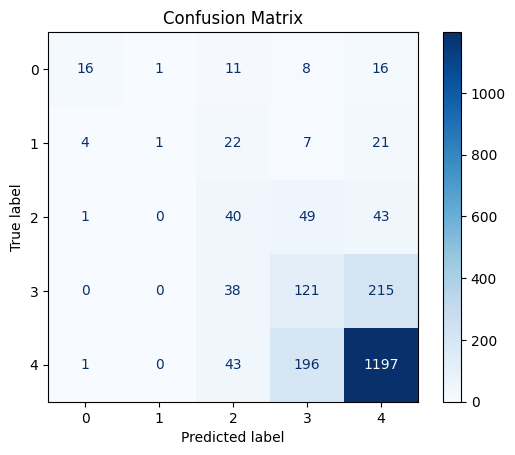

In [66]:

y_true = []
y_pred = []

for batch_x, batch_y in test_dataset:
    batch_pred = model(batch_x, training=False).numpy()
    y_true.extend(np.argmax(batch_y.numpy(), axis=1))
    y_pred.extend(np.argmax(batch_pred, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

VISUALISING USING ROC AND AUC 


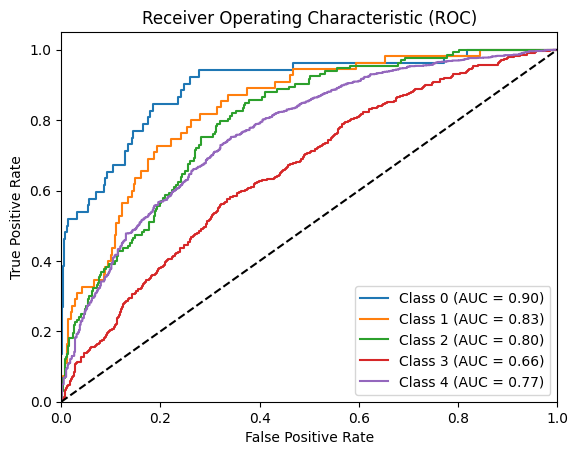

Class 0 AUC: 0.90
Class 1 AUC: 0.83
Class 2 AUC: 0.80
Class 3 AUC: 0.66
Class 4 AUC: 0.77


In [67]:
# Collect predictions and true labels
y_true = []
y_pred_proba = []

for batch_x, batch_y in test_dataset:
    batch_pred_proba = model(batch_x, training=False).numpy()
    y_true.extend(batch_y.numpy())
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Ensure y_true is in the correct shape (one-hot encoded format)
if y_true.ndim == 1:
    y_true = np.eye(y_pred_proba.shape[1])[y_true]

# Compute ROC AUC for each class
n_classes = y_pred_proba.shape[1]
auc_scores = []
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print AUC scores
for i, score in enumerate(auc_scores):
    print(f'Class {i} AUC: {score:.2f}')

CLASSIFICATION REPORT OF CNN 

In [68]:
#Collect predictions and true labels
y_true = []
y_pred = []

for batch_x, batch_y in test_dataset:
    batch_pred = model(batch_x, training=False).numpy()
    y_true.extend(np.argmax(batch_y.numpy(), axis=1))
    y_pred.extend(np.argmax(batch_pred, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute and print the classification report
report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(y_train.shape[1])])
print(report)

              precision    recall  f1-score   support

     Class 0       0.73      0.31      0.43        52
     Class 1       0.50      0.02      0.04        55
     Class 2       0.26      0.30      0.28       133
     Class 3       0.32      0.32      0.32       374
     Class 4       0.80      0.83      0.82      1437

    accuracy                           0.67      2051
   macro avg       0.52      0.36      0.38      2051
weighted avg       0.67      0.67      0.66      2051



In [69]:
#PREDICTION 
X = data[['reviewText', 'summary']]
X = X.fillna('')
X['combined'] = X['reviewText'] + " " + X['summary']

# Convert DataFrame to TensorFlow Dataset
def df_to_tf_dataset(df, batch_size=32):
    texts = df['combined'].values
    dataset = tf.data.Dataset.from_tensor_slices(texts)
    dataset = dataset.batch(batch_size)
    return dataset

# Create dataset
batch_size = 32
dataset = df_to_tf_dataset(X, batch_size)

In [70]:
def predict_ratings_batched(dataset, model, vectorizer):
    predictions = []
    
    for batch in dataset:
        # Vectorize the batch
        vectorized_batch = vectorizer(batch)
        
        # Predict the ratings
        batch_predictions = model.predict(vectorized_batch)
        
        # Convert to class predictions
        batch_predicted_classes = np.argmax(batch_predictions, axis=1)
        
        predictions.extend(batch_predicted_classes)
    
    return np.array(predictions)


In [71]:
# Make predictions
predicted_ratings = predict_ratings_batched(dataset, model, vectorizer)

# Add predictions to the DataFrame
data['predicted_rating'] = predicted_ratings

# Save the results to a CSV file
data.to_csv('Amazon_data_with_predictions.csv', index=False)

# Display the first few rows with predictions
print(data.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [72]:
# Collect predictions and true labels
y_true = []
y_pred_proba = []

for batch_x, batch_y in test_dataset:
    batch_pred_proba = model(batch_x, training=False).numpy()
    y_true.extend(batch_y.numpy())
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Ensure y_true is in the correct shape (one-hot encoded format)
if y_true.ndim == 1:
    y_true = np.eye(y_pred_proba.shape[1])[y_true]

# Convert predicted probabilities to class labels
predicted_ratings = np.argmax(y_pred_proba, axis=1)
true_ratings = np.argmax(y_true, axis=1)

# Ensure lengths are the same
assert len(predicted_ratings) == len(true_ratings), "Predicted and true ratings arrays must have the same length."

# Create DataFrame for plotting
prediction_counts = pd.DataFrame({
    'Actual Rating': true_ratings,
    'Predicted Rating': predicted_ratings
})

# Count occurrences
counts = prediction_counts.groupby(['Actual Rating', 'Predicted Rating']).size().reset_index(name='Count')

print(counts)

    Actual Rating  Predicted Rating  Count
0               0                 0     16
1               0                 1      1
2               0                 2     11
3               0                 3      8
4               0                 4     16
5               1                 0      4
6               1                 1      1
7               1                 2     22
8               1                 3      7
9               1                 4     21
10              2                 0      1
11              2                 2     40
12              2                 3     49
13              2                 4     43
14              3                 2     38
15              3                 3    121
16              3                 4    215
17              4                 0      1
18              4                 2     43
19              4                 3    196
20              4                 4   1197


VISUALISING THE THE CORRECT PREDICTION AND INCORRECT PREDICTION USING BAR CHART

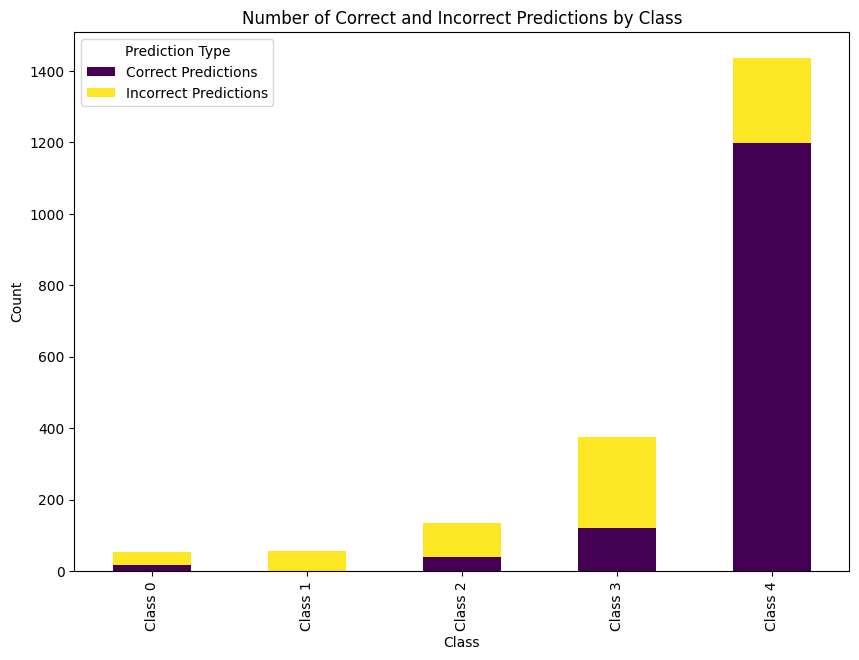

In [73]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_ratings, predicted_ratings)

# Extract counts for plotting
correct_predictions = np.diag(conf_matrix)
incorrect_predictions = conf_matrix.sum(axis=1) - correct_predictions

# Prepare data for plotting
classes = [f'Class {i}' for i in range(conf_matrix.shape[0])]
data = pd.DataFrame({
    'Class': classes,
    'Correct Predictions': correct_predictions,
    'Incorrect Predictions': incorrect_predictions
})

# Plot the bar chart
data.plot(x='Class', kind='bar', stacked=True, figsize=(10, 7), colormap='viridis')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Correct and Incorrect Predictions by Class')
plt.legend(title='Prediction Type')
plt.show()

NAIVE BAYES

              precision    recall  f1-score   support

     Class 1       0.05      0.14      0.07        51
     Class 2       0.02      0.06      0.03        53
     Class 3       0.07      0.26      0.11       140
     Class 4       0.21      0.33      0.25       411
     Class 5       0.72      0.30      0.42      1398

    accuracy                           0.29      2053
   macro avg       0.21      0.22      0.18      2053
weighted avg       0.54      0.29      0.35      2053



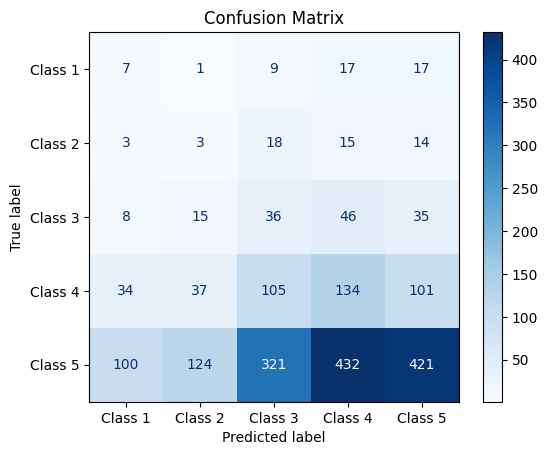

In [74]:

# Load and prepare data
data = pd.read_csv('Amazon_data.csv')
X = data[['reviewText', 'summary']]
X = X.fillna('')
X['combined'] = X['reviewText'] + " " + X['summary']
y = data['overall']

# Ensure y is in single class label format
if len(y.shape) > 1 and y.shape[1] > 1:  # Check if y is one-hot encoded
    y = np.argmax(y.values, axis=1)  # Convert one-hot to single class labels

# Encode labels to single class labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X['combined'], y, test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)  # Fit and transform training data
X_test_vec = vectorizer.transform(X_test)  # Transform test data

# Train Gaussian Naive Bayes model
model = GaussianNB()
model.fit(X_train_vec.toarray(), y_train)  # Convert sparse matrix to dense array

# Make predictions
y_pred = model.predict(X_test_vec.toarray())

# Compute and print classification report
target_names = [f'Class {i}' for i in label_encoder.classes_]
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


LOGISTIC REGRESSION 

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roam

              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00        51
     Class 2       0.00      0.00      0.00        53
     Class 3       0.43      0.16      0.23       140
     Class 4       0.43      0.22      0.29       411
     Class 5       0.75      0.96      0.84      1398

    accuracy                           0.71      2053
   macro avg       0.32      0.27      0.27      2053
weighted avg       0.63      0.71      0.65      2053



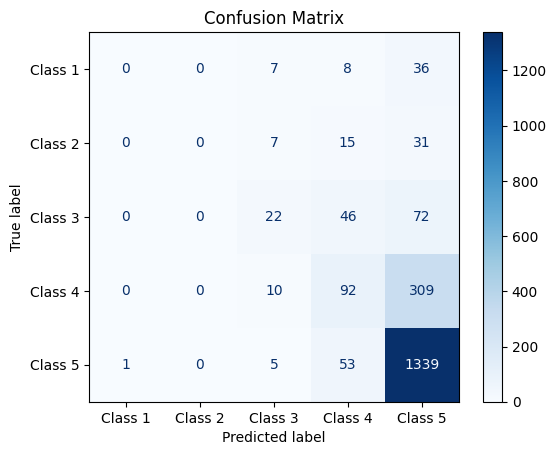

In [75]:

# Load and prepare data
data = pd.read_csv('Amazon_data.csv')
X = data[['reviewText', 'summary']]
X = X.fillna('')
X['combined'] = X['reviewText'] + " " + X['summary']
y = data['overall']

# Encode labels to single class labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X['combined'], y, test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)  # Fit and transform training data
X_test_vec = vectorizer.transform(X_test)  # Transform test data

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000, multi_class='auto')  # Use 'auto' to handle multiclass automatically
model.fit(X_train_vec, y_train)

# Make predictions
y_pred = model.predict(X_test_vec)

# Compute and print classification report
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in label_encoder.classes_])
print(report)

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[f'Class {i}' for i in label_encoder.classes_])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
